<a href="https://colab.research.google.com/github/Nitakaleo/Artificial-Intelligence-R195888Q-Assignment-2-/blob/main/Artificial_InR195888Qtelligence_Assignment_2_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**QUESTION 1** (Using the given dataset extract the relevant features that can define a customer churn.)

In [3]:
%matplotlib inline
import pandas as pd

import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [6]:
df = pd.read_csv('/content/drive/My Drive/f1/datasets_13996_18858_WA_Fn-UseC_-Telco-Customer-Churn (1).csv')

In [ ]:
df

In [35]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

for column in df.columns:
  if df[column].dtype == np.number:
    continue
  df[column] = encoder.fit_transform(df[column])

df.corr()['Churn']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  """


gender             -0.008612
SeniorCitizen       0.150889
Partner            -0.150448
Dependents         -0.164221
tenure             -0.352229
PhoneService        0.011942
MultipleLines       0.038037
InternetService    -0.047291
OnlineSecurity     -0.289309
OnlineBackup       -0.195525
DeviceProtection   -0.178134
TechSupport        -0.282492
StreamingTV        -0.036581
StreamingMovies    -0.038492
Contract           -0.396713
PaperlessBilling    0.191825
PaymentMethod       0.107062
MonthlyCharges      0.193356
TotalCharges        0.014479
Churn               1.000000
Name: Churn, dtype: float64

**QUESTION 2** (Using relevant mapping features show features which have the strongest correlation with churning.)

**EXPLORING DATA**

In [44]:
# Creates initial contingency table between Churn and gender. Male is 0, Female is 1.
gender_churn_contingency = pd.crosstab(df["gender"], df["Churn"])
display(gender_churn_contingency)


Churn,0,1
gender,,
0,2549,939
1,2625,930


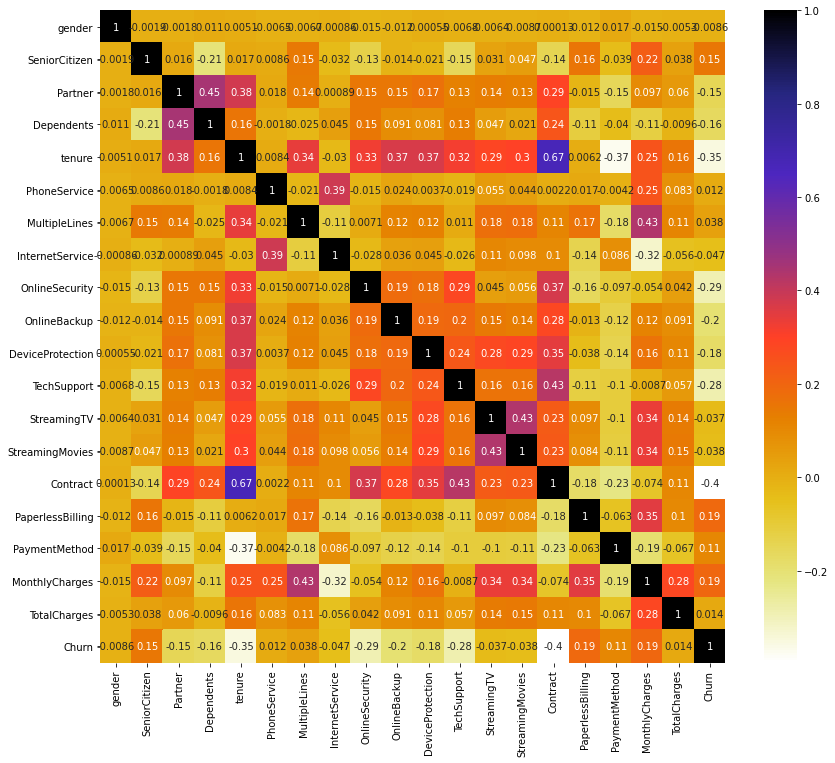

In [13]:
plt.figure(figsize=(14,12))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.CMRmap_r)
plt.show()

In [14]:
df.describe()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.504756,0.162147,0.483033,0.299588,32.371149,0.903166,0.940508,0.872923,0.790004,0.906432,0.904444,0.797104,0.985376,0.992475,0.690473,0.592219,1.574329,64.761692,3257.794122,0.265370
std,0.500013,0.368612,0.499748,0.458110,24.559481,0.295752,0.948554,0.737796,0.859848,0.880162,0.879949,0.861551,0.885002,0.885091,0.833755,0.491457,1.068104,30.090047,1888.693496,0.441561
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.250000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,9.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,35.500000,1609.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,29.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,2.000000,70.350000,3249.000000,0.000000
75%,1.000000,0.000000,1.000000,1.000000,55.000000,1.000000,2.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,2.000000,89.850000,4901.500000,1.000000
max,1.000000,1.000000,1.000000,1.000000,72.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,3.000000,118.750000,6530.000000,1.000000


In [15]:
def correlation(dataset, threshold):
  col_corr = set()
  corr_matrix = dataset.corr()
  for i in range(len(corr_matrix.columns)):
    for j in range(i):
      if (corr_matrix.iloc[i,j]) > threshold:
        colname = corr_matrix.columns[i]
        col_corr.add(colname)
  return col_corr

In [30]:
corr_aspects = correlation(cor,0.5)
len(set(corr_aspects))

10

In [31]:
corr_aspects

{'Contract',
 'Dependents',
 'DeviceProtection',
 'InternetService',
 'MonthlyCharges',
 'OnlineBackup',
 'OnlineSecurity',
 'StreamingMovies',
 'TechSupport',
 'tenure'}

**QUESTION 3** (define and train an Extreme Gradient Boosting “XGBOOST” model)

i)Extreme Gradient Boosting (XGBoost) is an open-source library that provides an efficient and effective implementation of the gradient boosting algorithm and decision trees that can be used for regression predictive modeling.

In [64]:
from sklearn.model_selection import train_test_split

In [65]:
cols_to_use = ['Contract', 'Dependents', 'DeviceProtection', 'MonthlyCharges', 'OnlineBackup', 'StreamingMovies', 'TechSupport','InternetService','OnlineSecurity','tenure']
X = df[cols_to_use]

# Selected target
y = df.Churn

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y)

In [66]:
from xgboost import XGBRegressor

my_model = XGBRegressor()
my_model.fit(Xtrain, ytrain)

[21:53:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

**QUESTION 4** (Evaluate the model’s accuracy and calculate the AUC value)

In [67]:
def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:

        xgb_param = alg.get_xgb_params() 
        
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        
        cvresult = xgb.cv(xgb_param, xgtrain, 
                          num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
                        metrics='auc', early_stopping_rounds=early_stopping_rounds)
        
        alg.set_params(n_estimators=cvresult.shape[0])
        
        print(alg.get_xgb_params())
    alg.fit(dtrain[predictors], dtrain['Churn'],eval_metric='auc')
    
    return alg

In [74]:
import sklearn.metrics as metrics

In [75]:
def get_accuracy(alg,predictors):
    dtrain_predictions = alg.predict(Xtest[predictors])
    dtrain_predprob = alg.predict_proba(Xtest[predictors])[:,1]
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(ytest.values, 
                                                      dtrain_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(ytest.values, 
                                                           dtrain_predprob))

In [76]:
target = 'Churn'
IDcol = 'customerID'

In [77]:
def drop_features(l):
    return [x for x in train.columns if x not in l]
    

In [78]:
from xgboost import XGBClassifier
train=pd.concat([Xtrain,ytrain],axis=1)
predictors = drop_features([target, IDcol])
my_model = XGBClassifier()
my_model.fit(Xtrain, ytrain)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [79]:
get_accuracy(my_model,predictors)


Model Report
Accuracy : 0.7956
AUC Score (Train): 0.850955
